# Link Timestamps with Win Percentage

In [577]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import datetime as dt
from difflib import get_close_matches
import matplotlib.pyplot as plt
from datetime import timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

## List of Good Games
The following games have more than 10,000 reddit comments, and good game timestamp data (I think).

In [28]:
gameids = ['7rzw8x','6yr619','7344it','7hm0s8','7611mn','77iet5',
           '74jzgn','7f0x8u','75d9nm','783zj0','7j6xjc','70z457',
           '78byz0','7ib3ma','7066zx','72gkav','73wset','7edv0u',
           '71n9hi','7bxqhr','7cjkt5','6zivwh','6zbv86','7khsre',
           '7kpp0u','7f2ii3','7b9o5g','7m4qjj','7gr8r5','76jy1v',
           '7lsa66','728u47','79k5lu','7iv8pw','7kf1if','79ruxo']

In [29]:
playbyplay = pd.read_csv('../../data/All_tweets_Feb17.csv')

In [30]:
winpct = pd.read_csv('../../data/All_plays_Feb17.csv')

In [31]:
playbyplay.head()

,tweet_id,Game Title Date,text_cleaned,UTC_Datetime,playnum,playId,Game Title Date.1,text,homeWinPercentage
0,9.059546e+17,Chiefs vs. Patriots 2017-09-07,C.Santos kicks 64 yards from KC 35 to NE 1. D....,2017-09-08 00:43:00,40174.0,4.009517e+12,Giants vs. Raiders 2017-12-03,(14:30) M.Lynch left tackle to OAK 45 for 5 ya...,0.741
1,9.059546e+17,Chiefs vs. Patriots 2017-09-07,C.Santos kicks 64 yards from KC 35 to NE 1. D....,2017-09-08 00:43:00,40175.0,4.009517e+12,Giants vs. Raiders 2017-12-03,(13:46) (Shotgun) D.Carr pass short right to S...,0.769
2,9.059548e+17,Chiefs vs. Patriots 2017-09-07,(14:55) NE 12-Brady 18th season as Patriots QB...,2017-09-08 00:44:00,40176.0,4.009517e+12,Giants vs. Raiders 2017-12-03,(13:03) D.Washington up the middle to OAK 49 f...,0.722
3,9.059548e+17,Chiefs vs. Patriots 2017-09-07,T.Brady pass incomplete deep left to D.Allen. ...,2017-09-08 00:44:00,40177.0,4.009517e+12,Giants vs. Raiders 2017-12-03,(12:23) (Shotgun) D.Carr pass short right to J...,0.781
4,9.059548e+17,Chiefs vs. Patriots 2017-09-07,(14:55) NE 12-Brady 18th season as Patriots QB...,2017-09-08 00:44:01,40178.0,4.009517e+12,Giants vs. Raiders 2017-12-03,(11:48) (Shotgun) D.Carr pass short right to M...,0.825


In [32]:
winpct.head()

,Unnamed: 0,playnum,playId,Game Title Date,text,homeWinPercentage
0,8627,43825,4.009517e+10,49ers vs. Bears 2017-12-03,P.O'Donnell kicks 65 yards from CHI 35 to end ...,0.685
1,47956,43826,4.009517e+10,49ers vs. Bears 2017-12-03,(15:00) (Shotgun) J.Garoppolo pass incomplete ...,0.711
2,35375,43827,4.009517e+10,49ers vs. Bears 2017-12-03,(14:55) C.Hyde right end to SF 25 for no gain ...,0.722
3,23191,43828,4.009517e+10,49ers vs. Bears 2017-12-03,(14:12) (Shotgun) J.Garoppolo pass short right...,0.663
4,35376,43829,4.009517e+11,49ers vs. Bears 2017-12-03,(13:39) M.Breida left end to SF 48 for 8 yards...,0.650


In [33]:
gameinfo = pd.read_csv('../../data/Game_Thread_List_Only.csv')

In [34]:
gameinfo.head()

,Unnamed: 0,Date,Thread Title,Thread ID,Thread Name,Number of Comments,Score,Subreddit,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,437,Aug-31-2017,Game Thread: Los Angeles Chargers (1-2) at San...,6xbdec,t3_6xbdec,112,21,nfl,NaN,NaN,NaN
1,478,Dec-31-2017,Game Thread: Washington Redskins (7-8) at New ...,7n9q5s,t3_7n9q5s,612,56,nfl,NaN,NaN,NaN
2,492,Aug-27-2017,Game Thread: Cincinnati Bengals (1-1) at Washi...,6wedvg,t3_6wedvg,616,71,nfl,NaN,NaN,NaN
3,487,Aug-26-2017,Game Thread: Los Angeles Chargers (0-2) at Los...,6w8wq7,t3_6w8wq7,619,85,nfl,NaN,NaN,NaN
4,496,Nov-12-2017,Game Thread: New York Jets (4-5) at Tampa Bay ...,7cgped,t3_7cgped,632,56,nfl,NaN,NaN,NaN


In [379]:
good_data_games = gameinfo.loc[gameinfo['Thread ID'].isin(gameids)].copy()
good_data_games['Date'] = pd.to_datetime(good_data_games['Date'])

In [380]:
# Filter Play by Play Tweets
unique_game_dates = winpct['Game Title Date'].unique().tolist()

In [381]:
good_data_games['Game and Date'] = good_data_games.apply(lambda x: x['Thread Title'].replace('Game Thread: ','') + ' ' + x['Date'].strftime("%Y-%m-%d"), axis=1)[243]

In [382]:
get_close_matches(denv_chiefs_2017_10_30, unique_game_dates)

['Broncos vs. Chiefs  2017-10-30']

In [383]:
def get_game_name(col):
    game = col['Thread Title'].replace('Game Thread: ','')
    datename = col['Date'].strftime("%Y-%m-%d") 
    # print(game + ' ' + datename)
    match = get_close_matches(game + ' ' + datename, unique_game_dates)
    # print('matched with...')
    # print(match)
    if len(match) == 0:
        return 'no match'
    return match

In [384]:
get_game_name(good_data_games.loc[243])

['Broncos vs. Chiefs  2017-10-30']

In [385]:
good_data_games['matched_game_date'] = good_data_games.apply(get_game_name, axis=1)['Date']

In [386]:
good_data_games.loc[253, 'matched_game_date'] = 'Raiders vs. Eagles  2017-12-25'
good_data_games.loc[270, 'matched_game_date'] = 'Rams vs. 49ers  2017-09-21'
good_data_games.loc[277, 'matched_game_date'] = 'Redskins vs. Eagles  2017-10-23'
good_data_games.loc[290, 'matched_game_date'] = 'Eagles vs. Panthers  2017-10-12'
good_data_games.loc[301, 'matched_game_date'] = 'Chiefs vs. Patriots  2017-09-07'
good_data_games.loc[304, 'matched_game_date'] = 'Jaguars vs. Patriots  2018-01-21'

In [387]:
good_data_games = good_data_games.drop('Unnamed: 0', axis=1)

In [388]:
good_data_games.to_csv('../../data/Good_Games_with_DateGameNames.csv')

# Start with one game

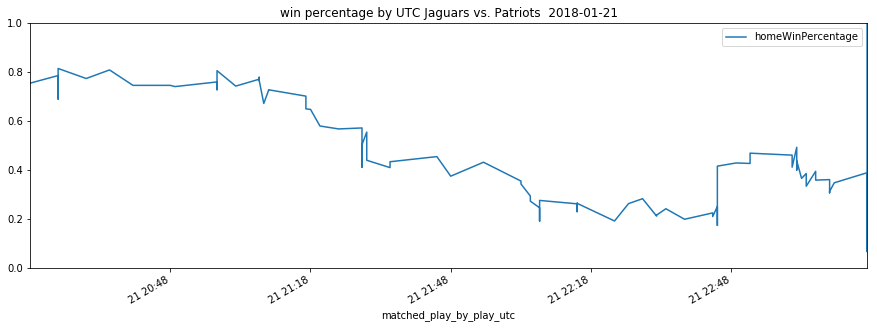

In [461]:
game_winpct['matched_play_by_play_utc'] = pd.to_datetime(game_winpct['matched_play_by_play_utc'])
game_winpct.plot(x='matched_play_by_play_utc', y='homeWinPercentage', ylim=(0,1), figsize=(15,5), title='win percentage by UTC {}'.format(game))

/home/robmulla/miniconda3/envs/w266/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


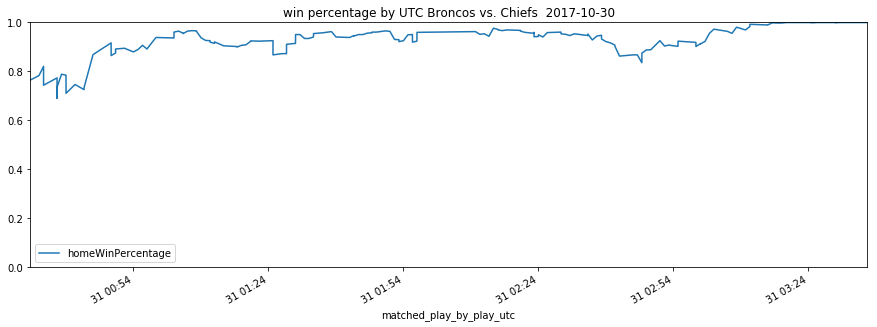

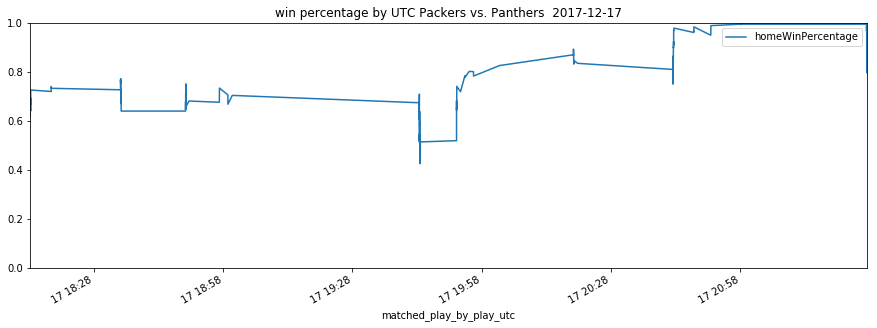

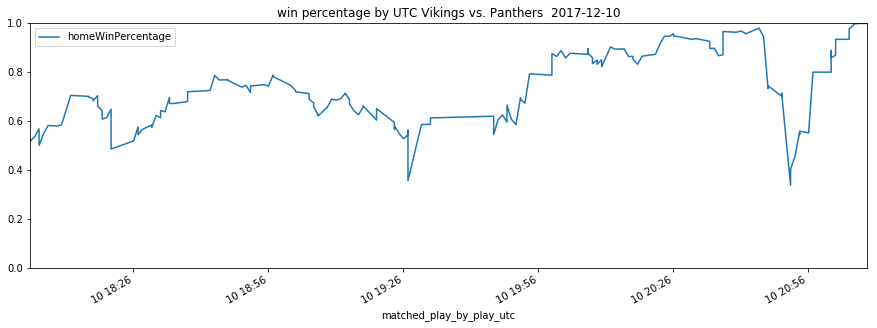

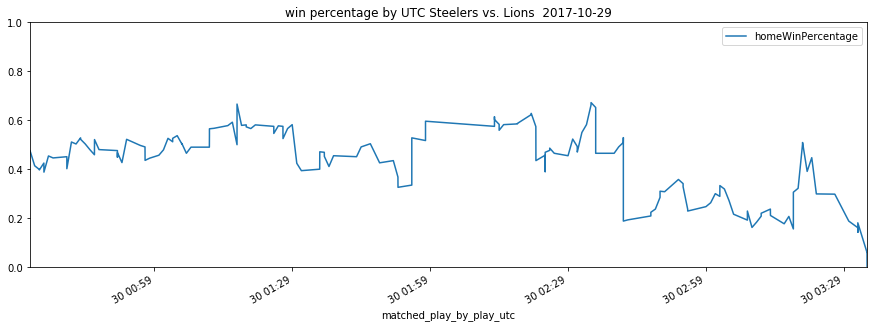

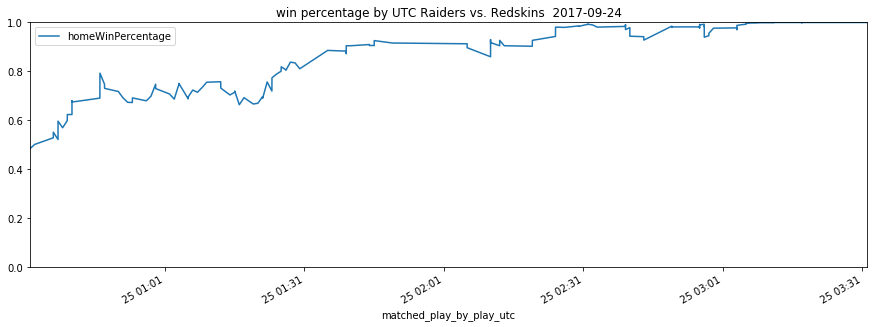

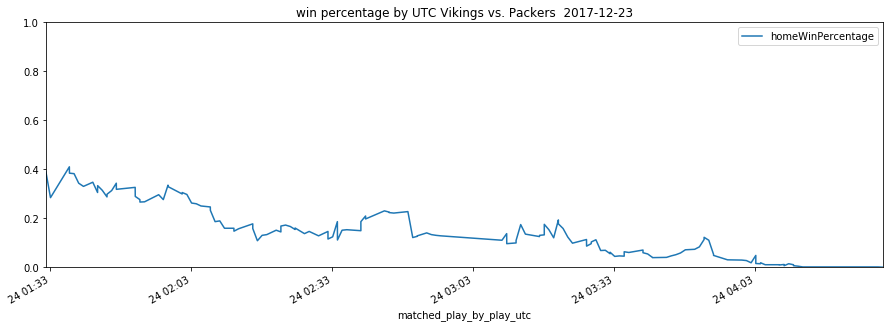

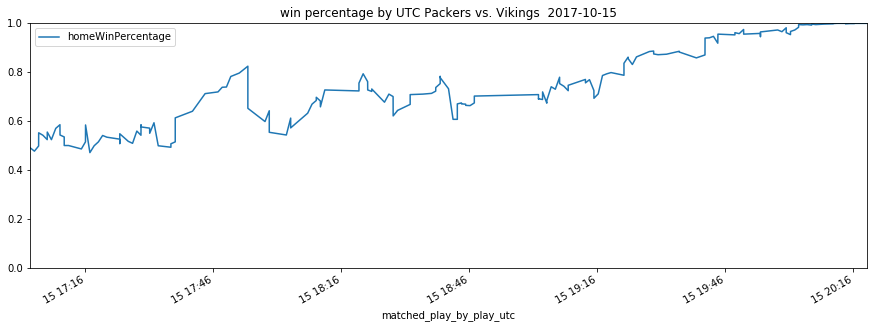

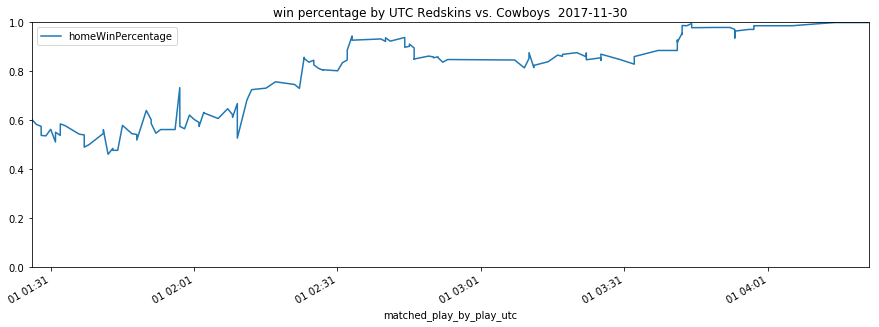

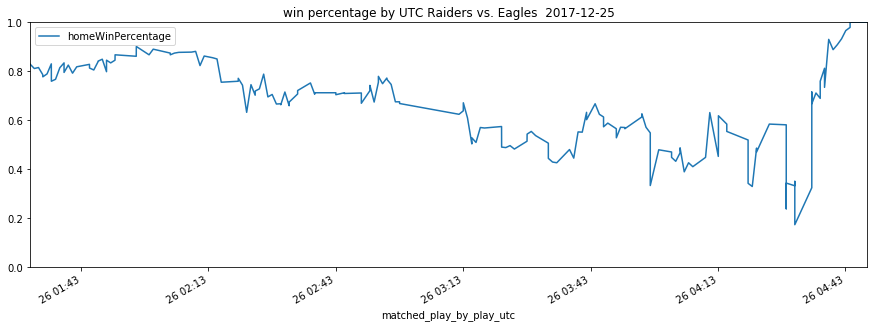

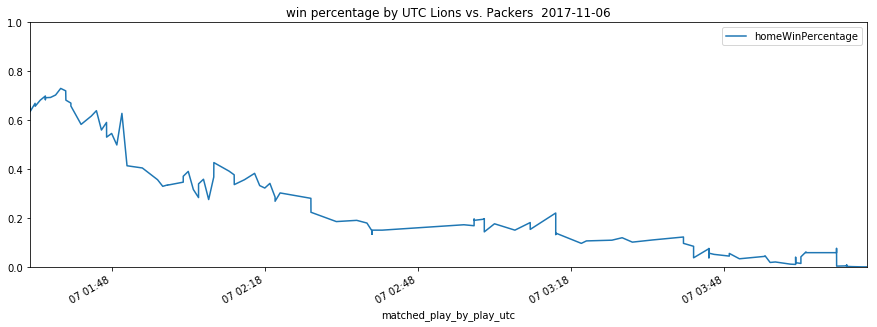

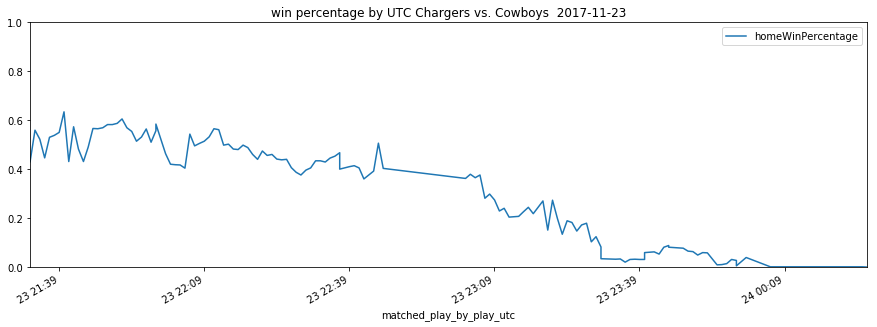

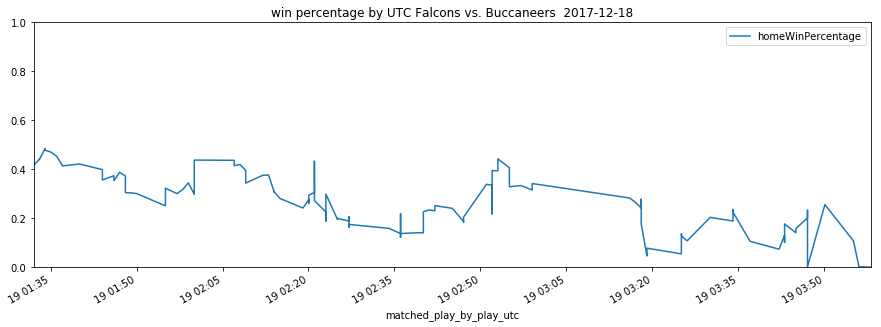

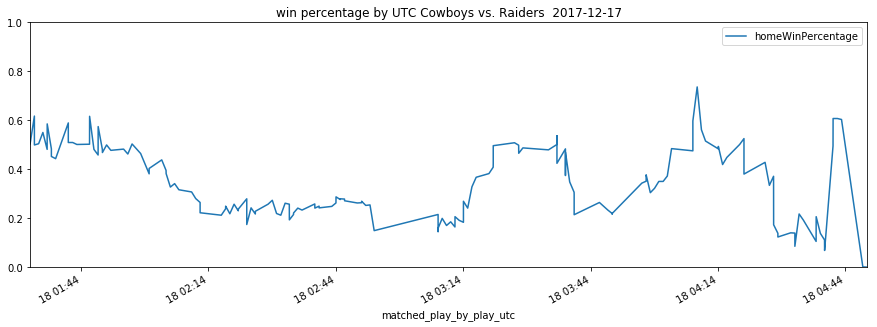

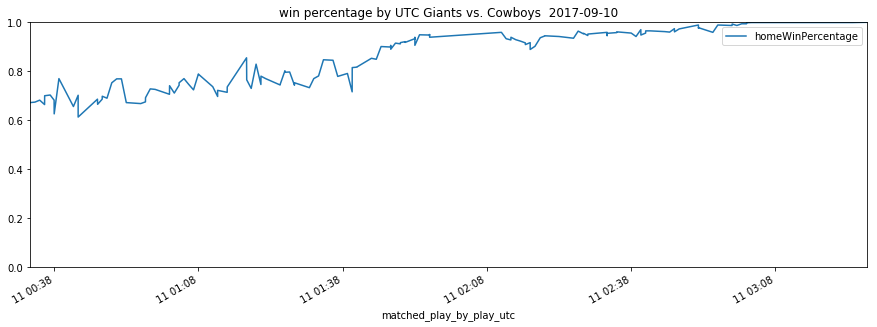

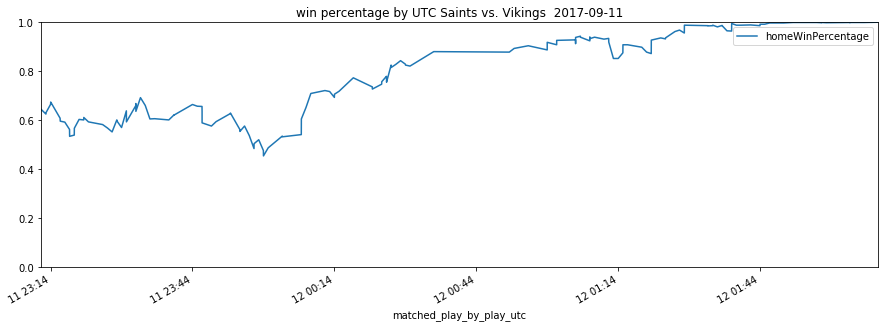

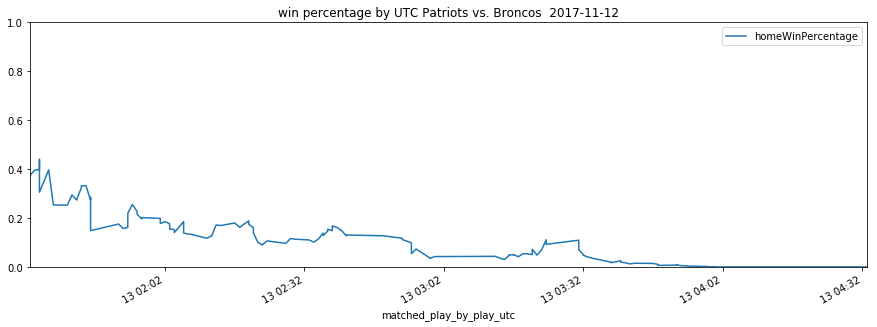

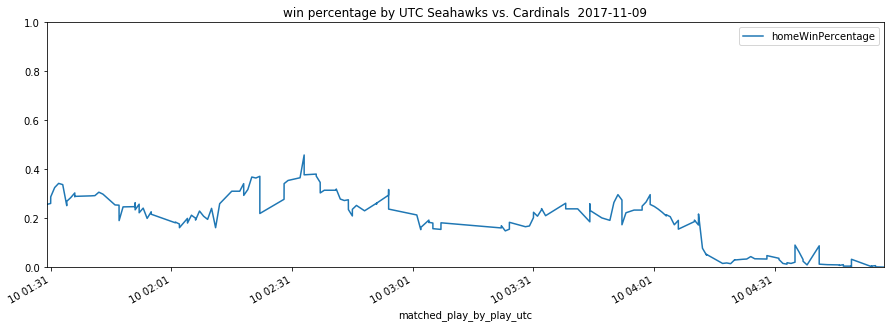

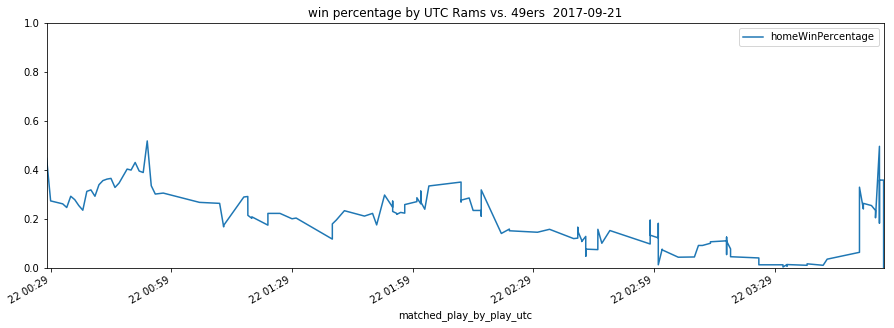

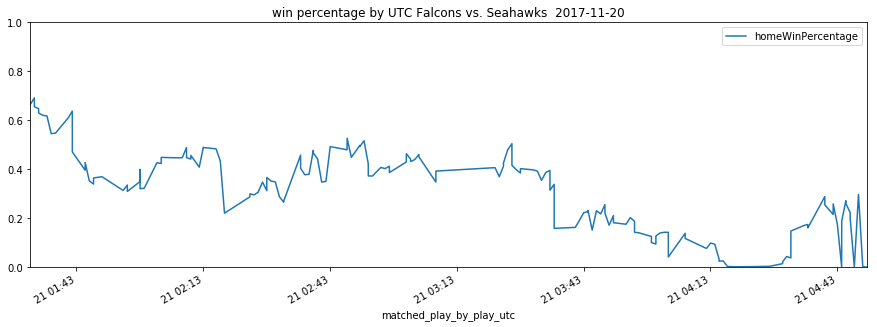

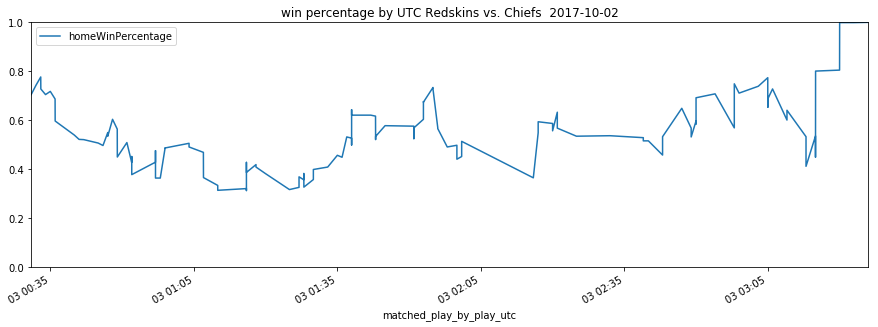

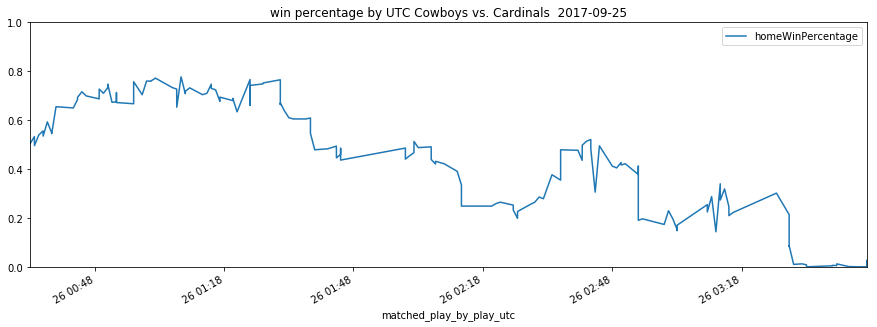

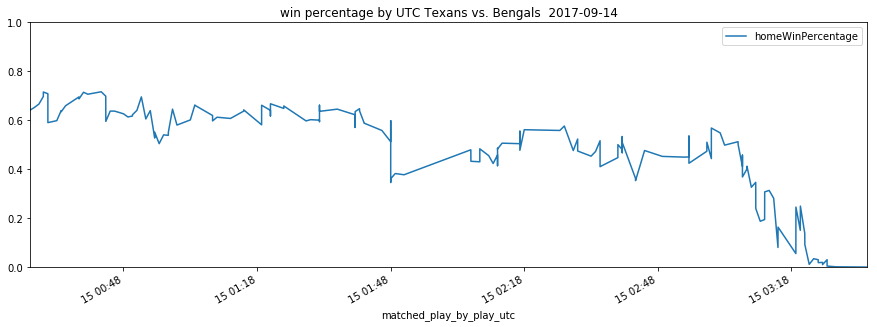

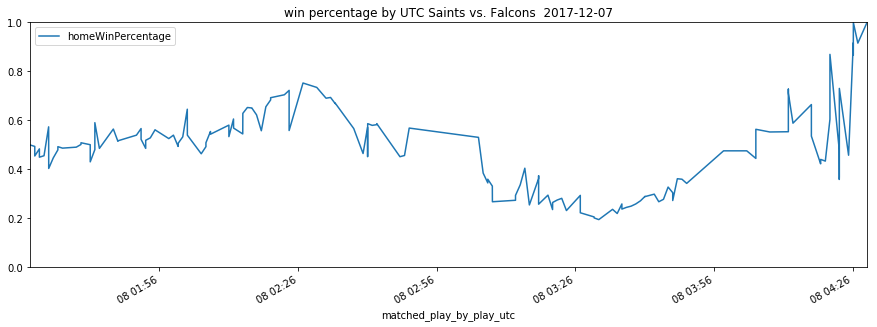

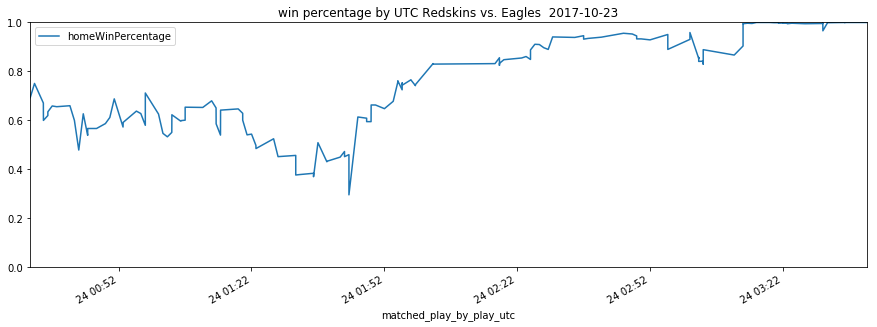

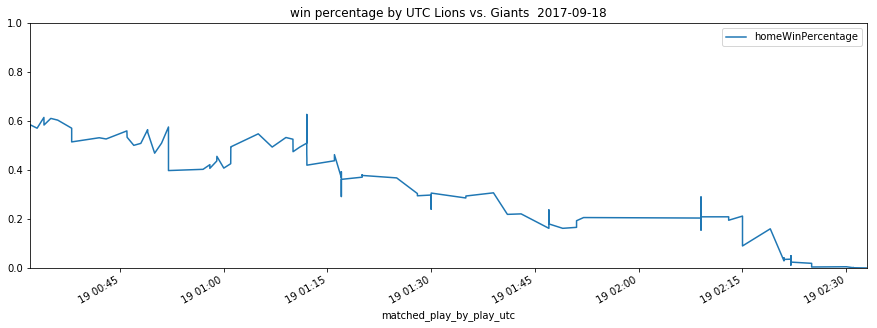

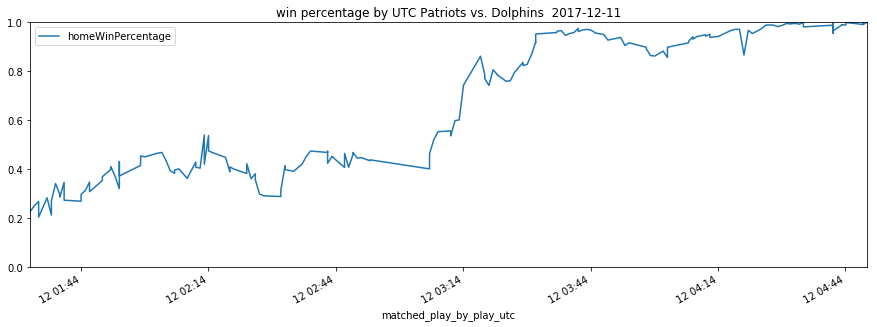

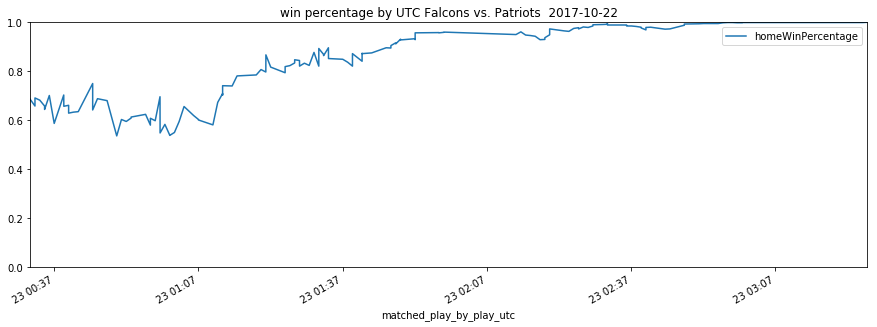

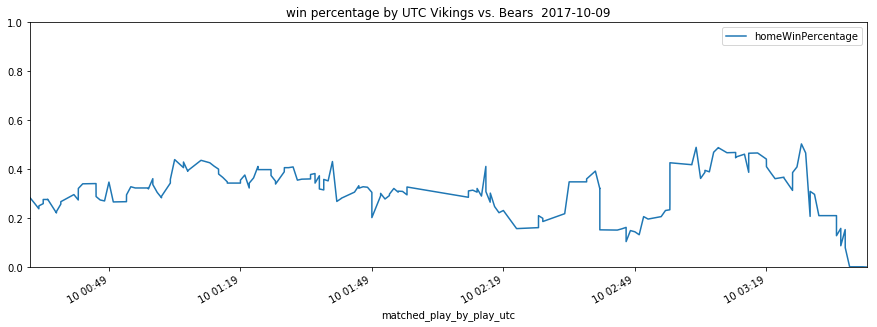

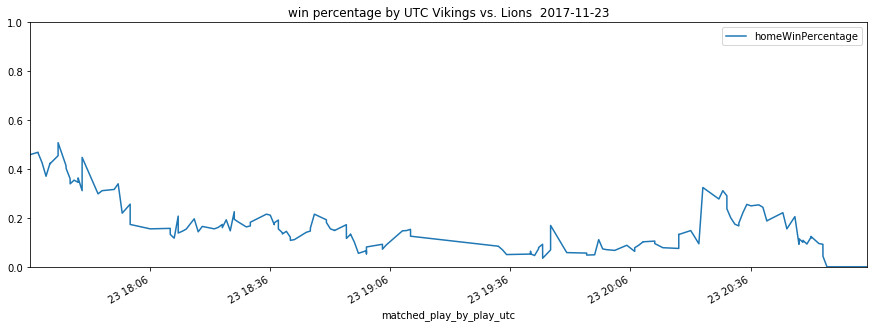

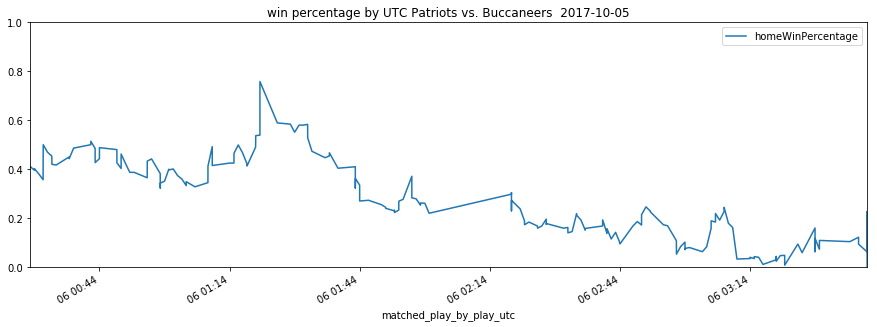

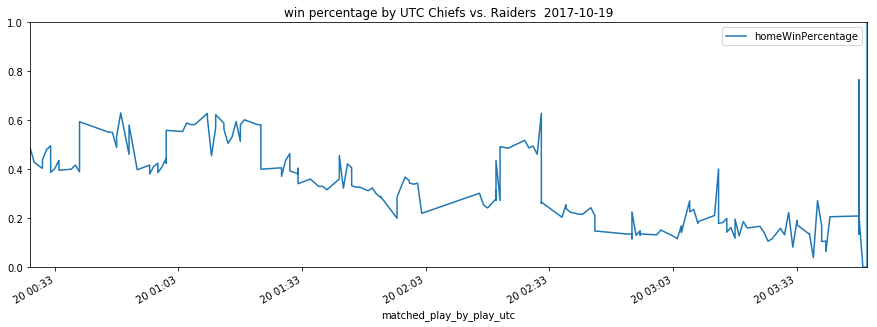

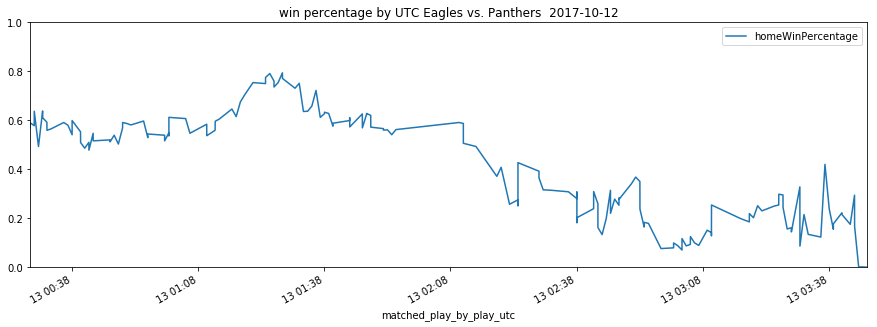

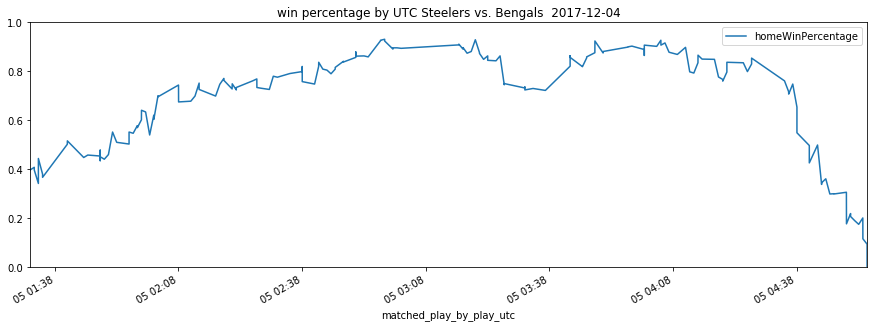

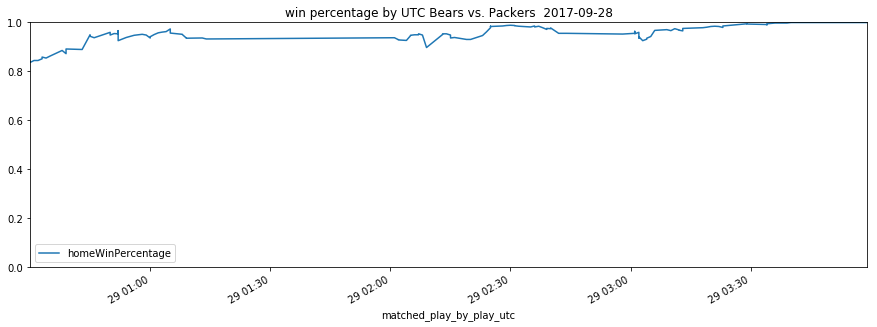

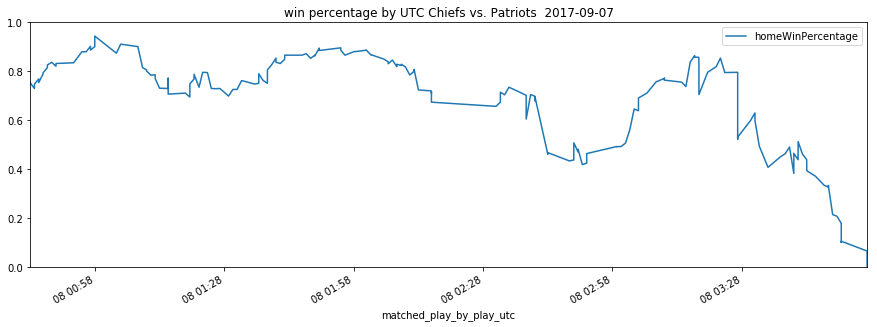

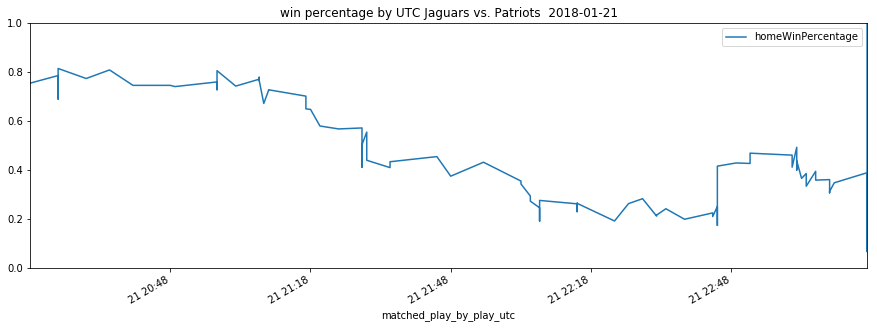

In [462]:
for ind in good_data_games.index:
    #print(ind)
    game = good_data_games.loc[ind]['matched_game_date']

    #print(game)

    # filter win percentage 
    game_winpct = winpct.loc[winpct['Game Title Date'] == game].copy().reset_index()
    game_playbyplay = playbyplay.loc[playbyplay['Game Title Date'] == game].copy().reset_index()

    # Plot play by play to make sure it looks reasonible
    #game_playbyplay.plot('UTC_Datetime', y='tweet_id', figsize=(15,5), title='Tweets timeline : {}'.format(game))

    # Loop through win percent and match with play by play get UTC
    first_index = 0
    for i in game_winpct.iterrows():
        pbp_text = i[1]['text']
        # print(pbp_text)
        next_10_playbyplay = game_playbyplay['text_cleaned'][first_index:first_index+10]
        match = process.extractOne(pbp_text, next_10_playbyplay)
        # print(match)
        match_text, match_percent, match_index = match
        game_winpct.loc[i[0], 'matched_play_by_play_text'] = match_text
        game_winpct.loc[i[0], 'matched_play_by_play_index'] = match_index
        game_winpct.loc[i[0], 'matched_play_by_play_utc'] = game_playbyplay.loc[match_index]['UTC_Datetime']
        game_winpct.loc[i[0], 'matched_play_by_play_tweetid'] = game_playbyplay.loc[match_index]['tweet_id']
        first_index = match_index

    game_winpct['matched_play_by_play_utc'] = pd.to_datetime(game_winpct['matched_play_by_play_utc'])
    game_winpct.plot(x='matched_play_by_play_utc', y='homeWinPercentage', ylim=(0,1), figsize=(15,5), title='win percentage by UTC {}'.format(game))

    game_winpct['home_team'] = game_winpct.loc[0, 'Game Title Date'].split()[2]
    game_winpct['away_team'] = game_winpct.loc[0, 'Game Title Date'].split()[0]
    game_winpct['awayWinPercentage'] = 1 - game_winpct['homeWinPercentage']
    
    # Save to CSV
    filename = game.replace(' ','_').replace('.','') + '_UTCandWinPCT.csv'
    game_winpct.to_csv('../../data/Clean_Game_Data/' + filename)

# Load in Comments

In [463]:
comments = pd.read_pickle('../../../data/7rzw8x_parsed_comments.pickle')

In [465]:
comments = comments[['author_flair',
                      'comment_created_utc_datetime',
                      'comment_body',
                      'score']].sort_values('comment_created_utc_datetime').copy()

In [466]:
comments = comments.sort_values('comment_created_utc_datetime')

In [486]:
comments.loc[comments['comment_created_utc_datetime'] == '2018-01-21 18:17:09']

,author_flair,comment_created_utc_datetime,comment_body,score
55906,Patriots,2018-01-21 18:17:09,Soak it in brother. Soak it in :),2
61111,Patriots,2018-01-21 18:17:09,That's pretty fucked up nah,1


In [490]:
df = game_winpct.copy()
df['UTC_Datetime'] = pd.to_datetime(df['matched_play_by_play_utc'])

# Loop through comments
from datetime import timedelta

only_greater = df.copy()

playidlist = []
for row in comments.itertuples():
    mytime = row[2] + timedelta(hours=5)
    #print(mytime)
    only_greater = only_greater.loc[df['UTC_Datetime'] >= mytime]
    try:
        playid_attime = only_greater.head(1)['playId'].values[0]
        #print(winpct_attime)
        playidlist.append(playid_attime)
    except:
        #print(mytime)
        #raise
        playidlist.append(playid_attime)

comments['playId'] = playidlist
merged = comments.merge(game_winpct, on='playId')

# Put it together

Broke for Patriots vs. Broncos  2017-11-12


/home/robmulla/miniconda3/envs/w266/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Broke for Vikings vs. Bears  2017-10-09
Broke for Vikings vs. Lions  2017-11-23
Broke for Patriots vs. Buccaneers  2017-10-05


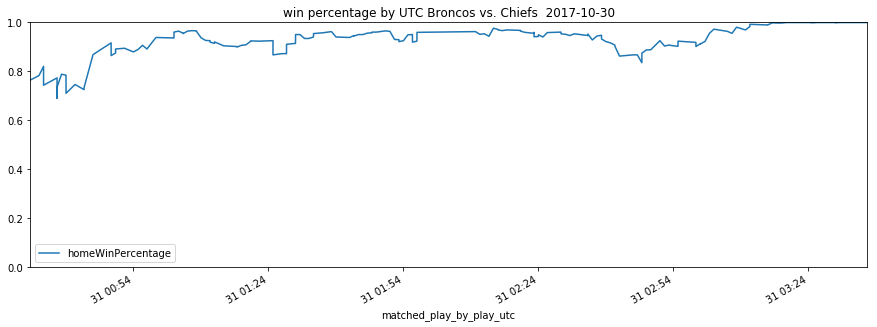

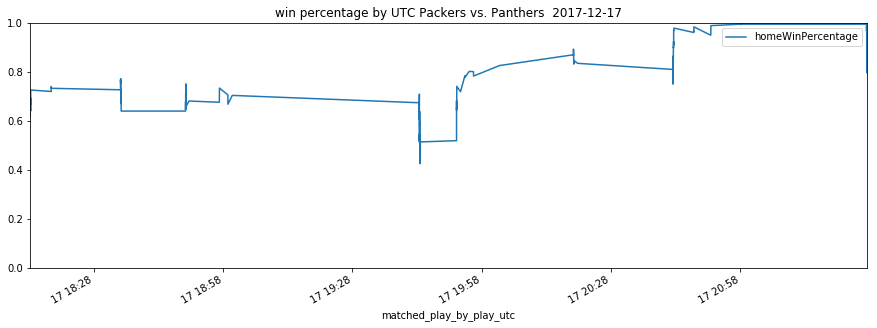

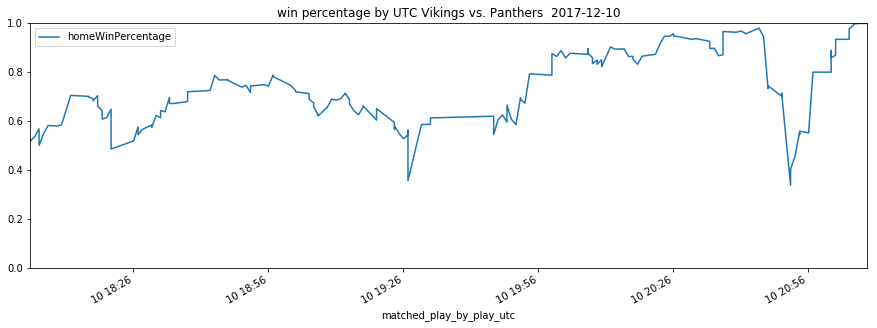

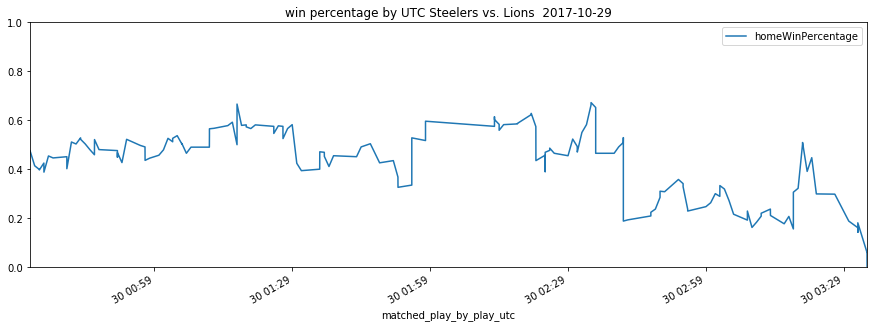

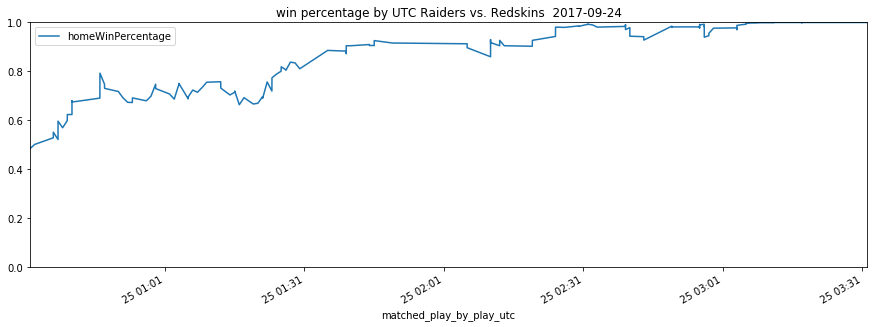

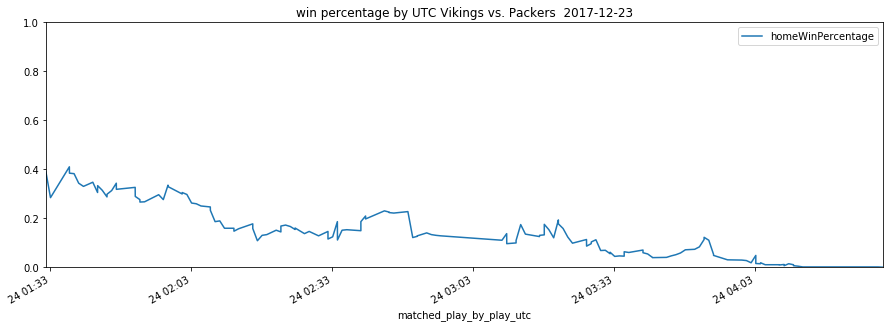

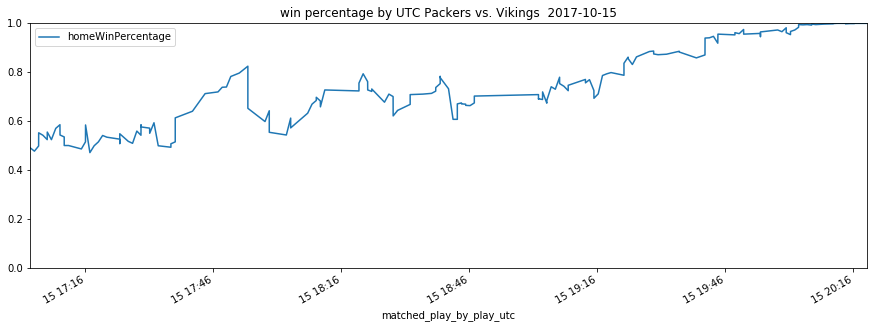

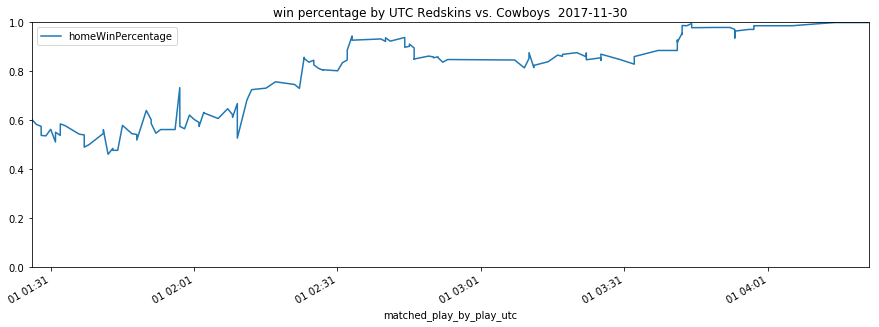

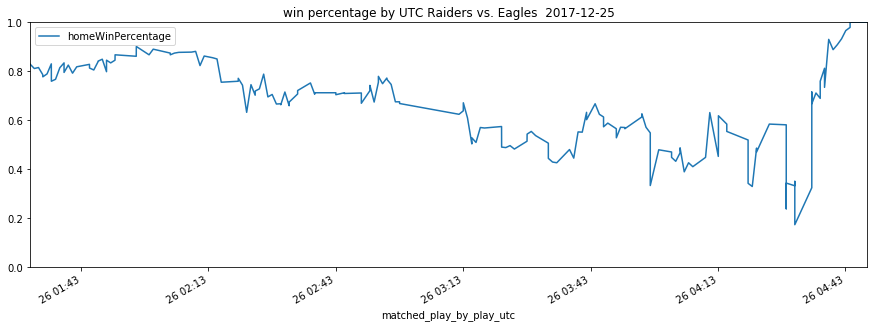

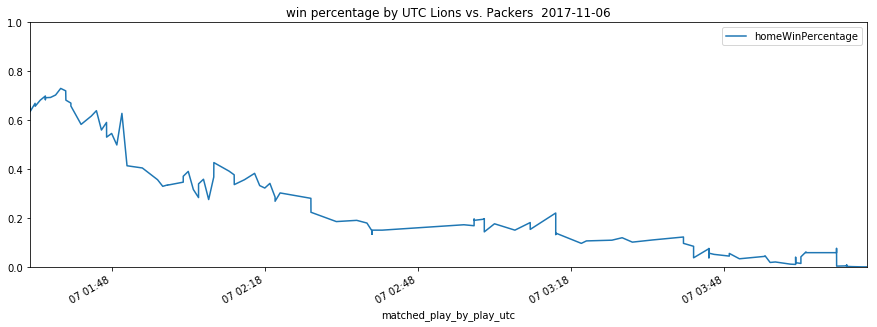

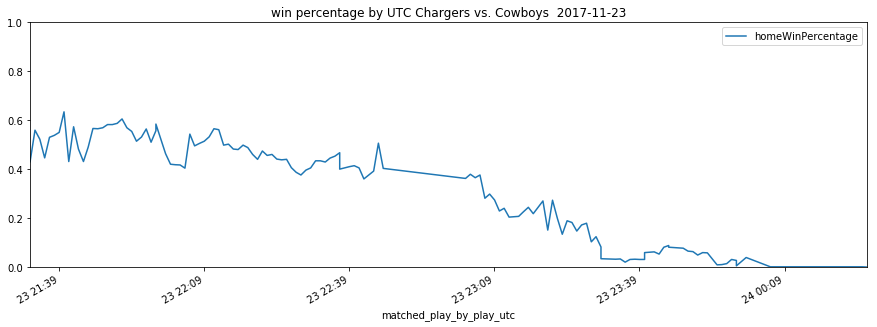

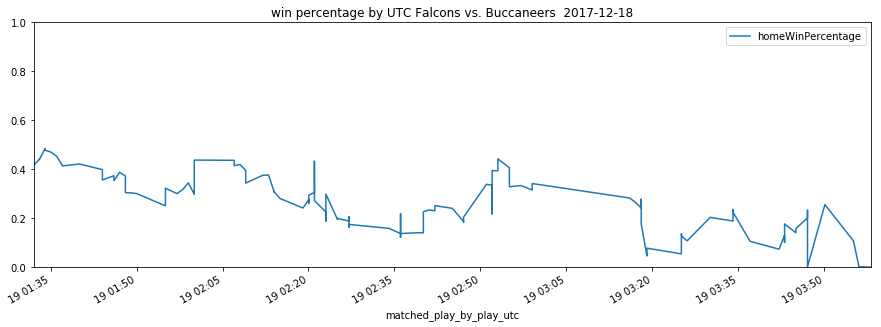

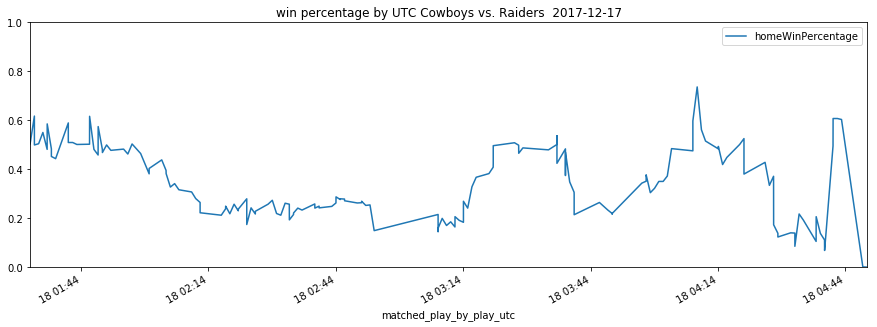

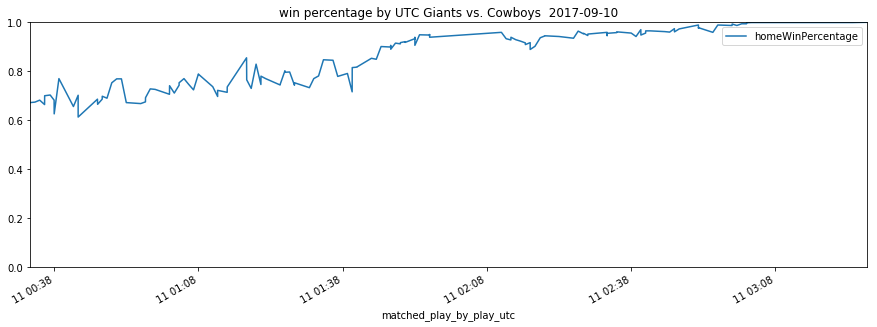

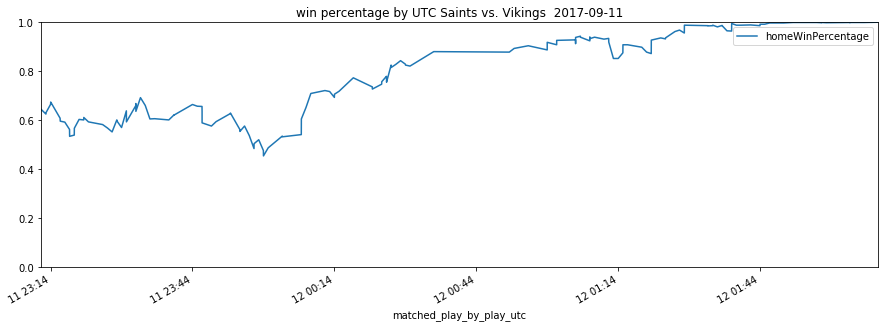

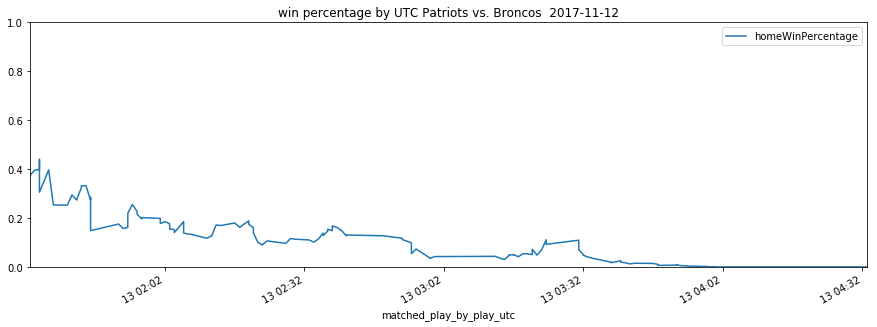

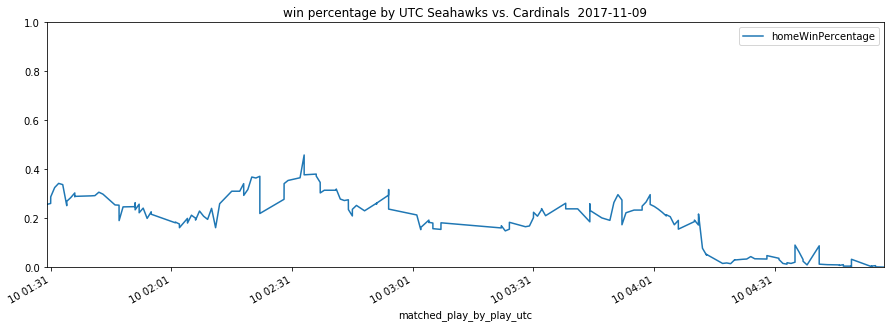

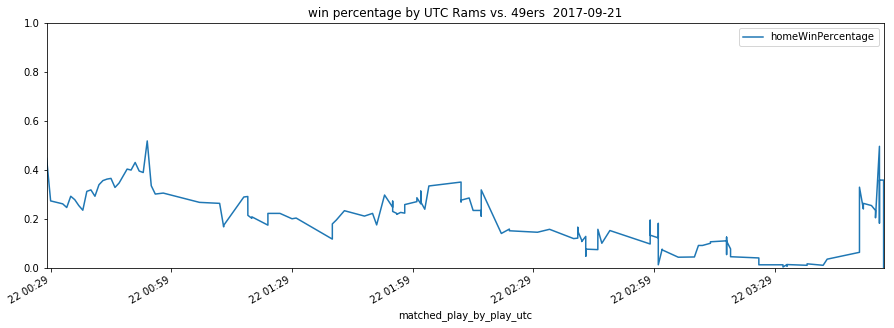

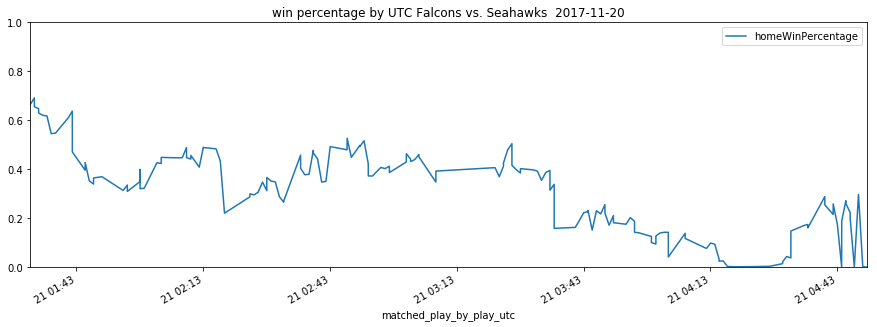

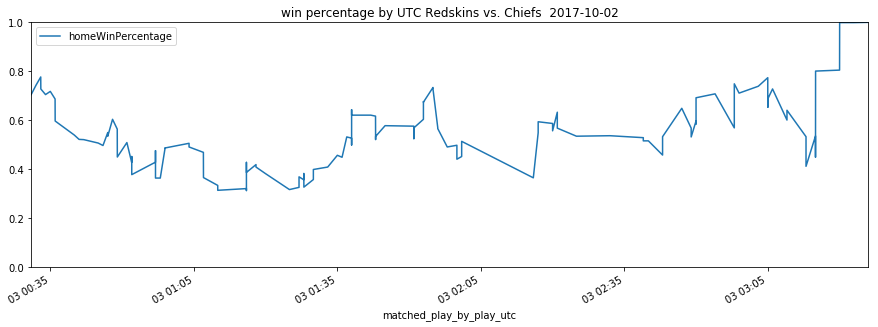

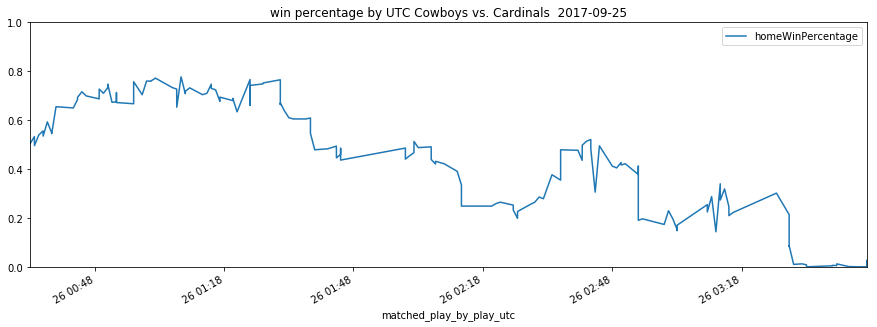

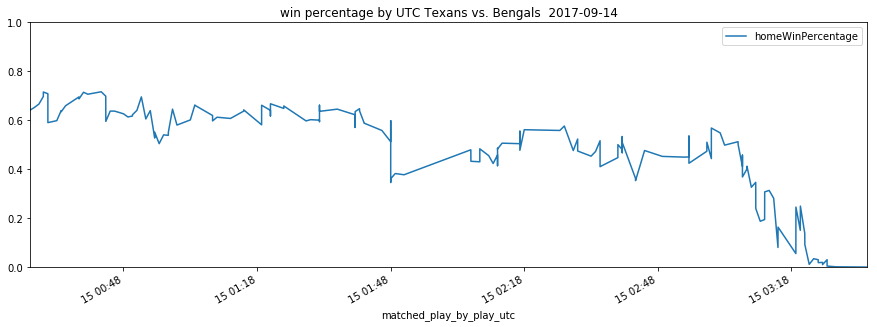

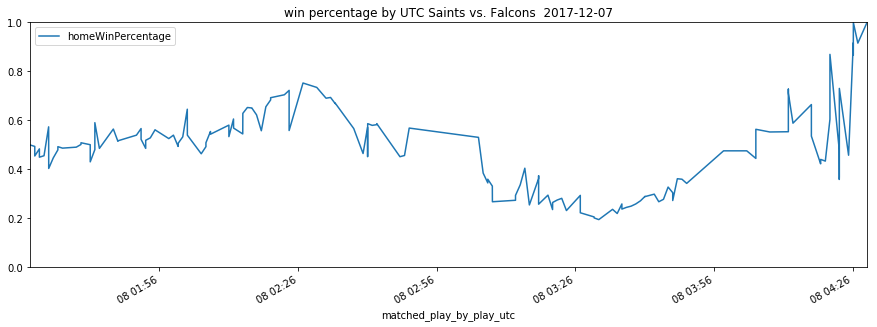

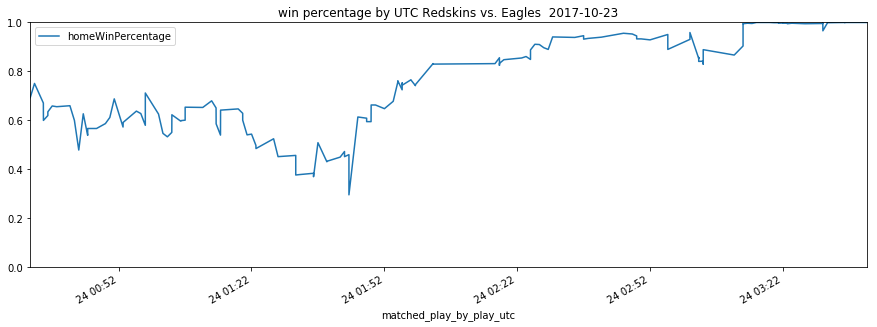

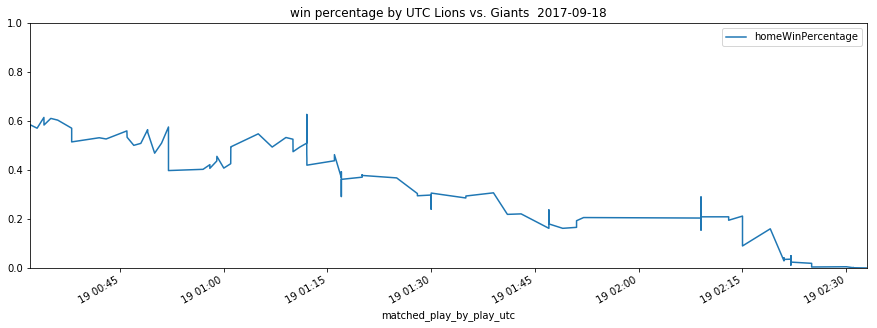

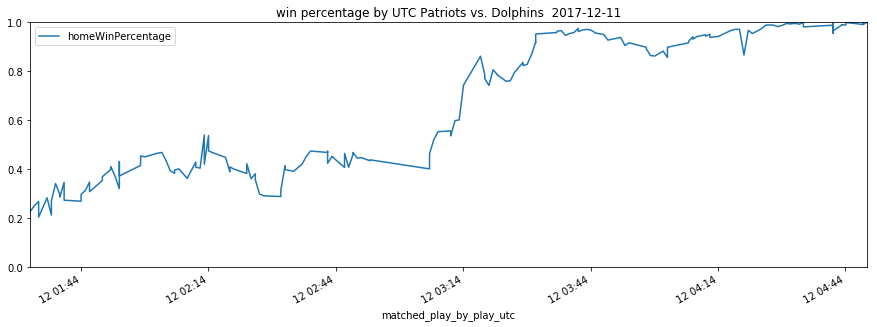

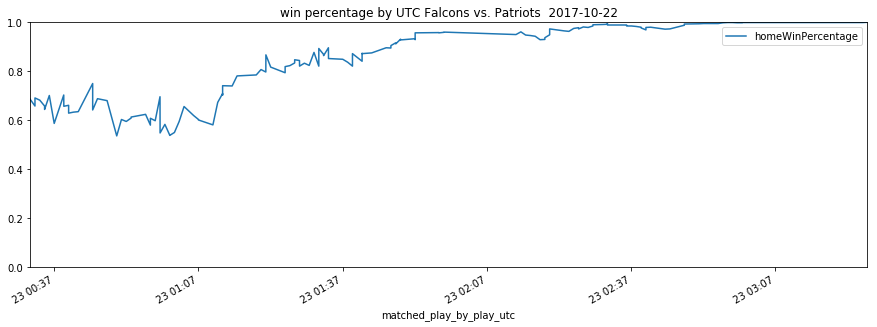

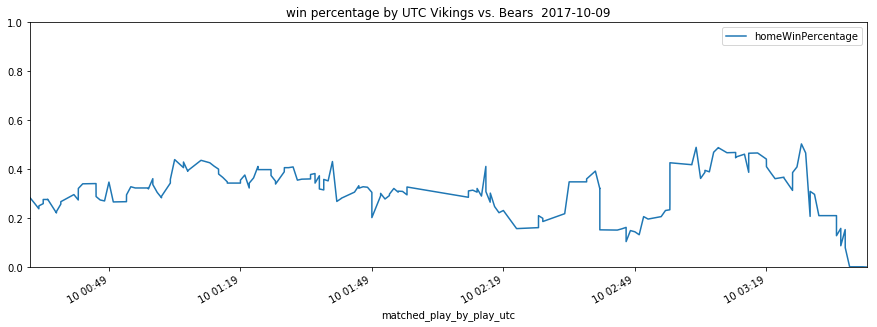

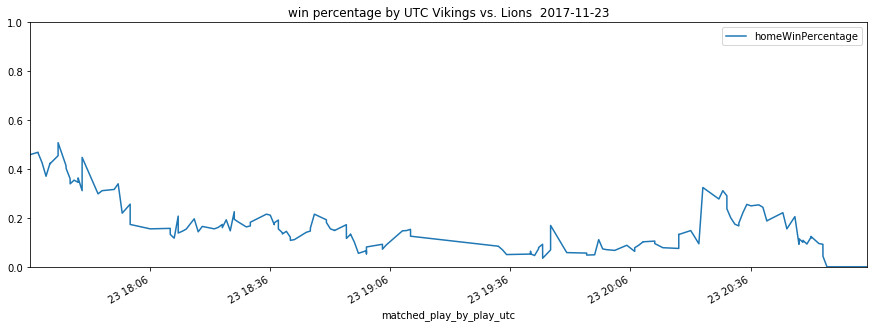

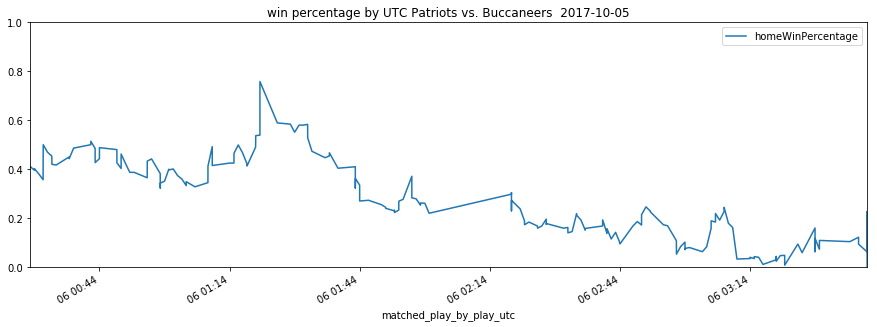

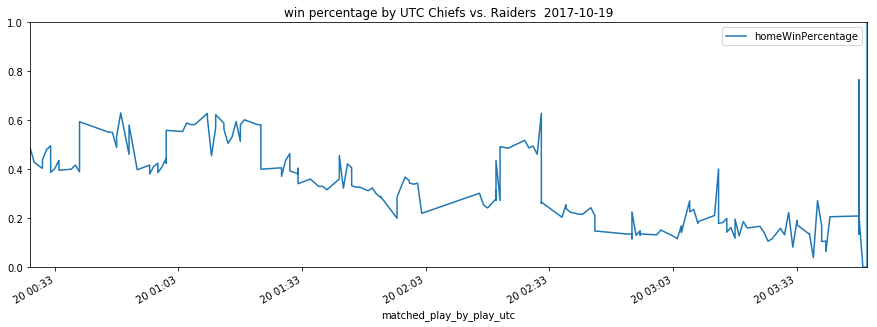

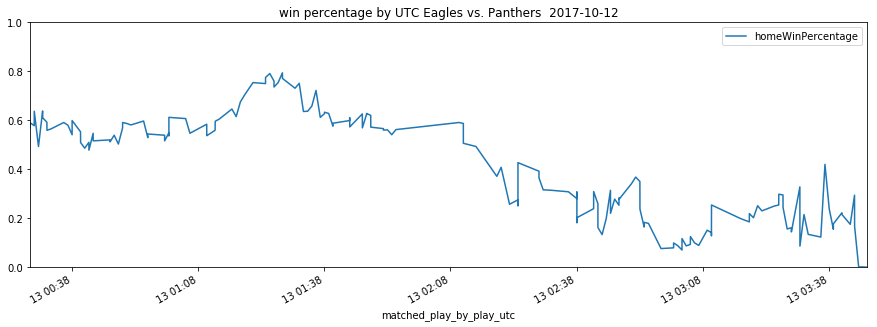

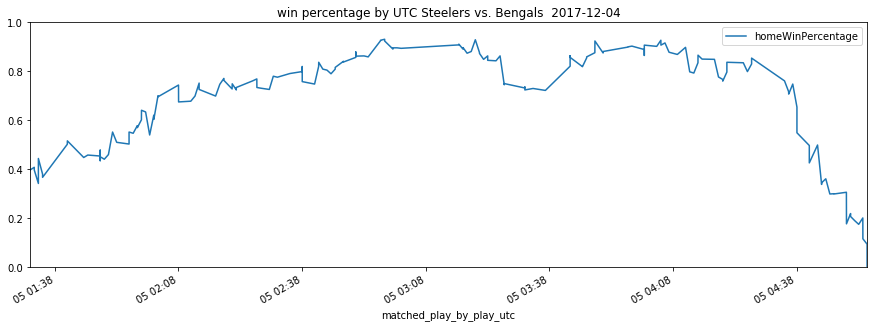

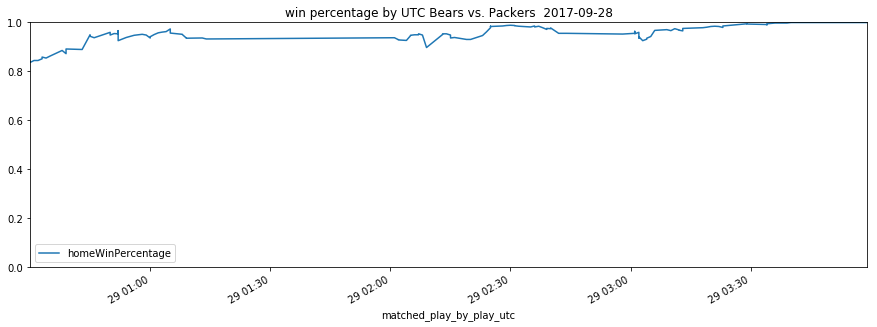

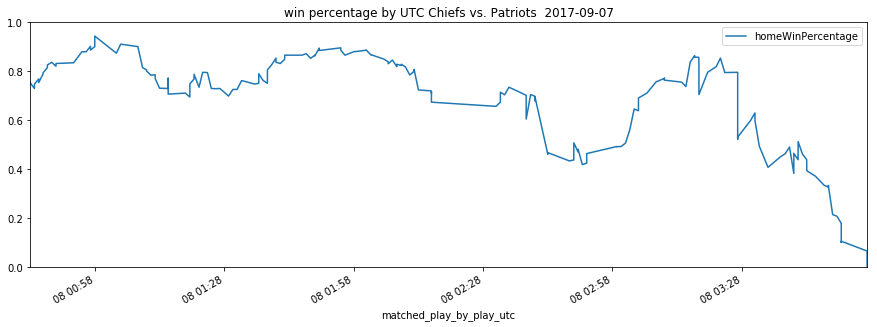

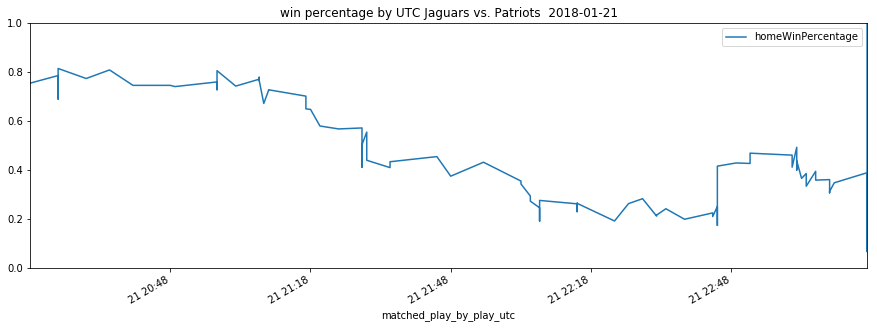

In [604]:
for ind in good_data_games.index:


    game = good_data_games.loc[ind]['matched_game_date']
    thread = good_data_games.loc[ind]['Thread ID']
    try:
        # filter win percentage 
        game_winpct = winpct.loc[winpct['Game Title Date'] == game].copy().reset_index()
        game_playbyplay = playbyplay.loc[playbyplay['Game Title Date'] == game].copy().reset_index()

        # Plot play by play to make sure it looks reasonible
        #game_playbyplay.plot('UTC_Datetime', y='tweet_id', figsize=(15,5), title='Tweets timeline : {}'.format(game))

        # Loop through win percent and match with play by play get UTC
        first_index = 0
        for i in game_winpct.iterrows():
            pbp_text = i[1]['text']
            # print(pbp_text)
            next_10_playbyplay = game_playbyplay['text_cleaned'][first_index:first_index+10]
            match = process.extractOne(pbp_text, next_10_playbyplay)
            # print(match)
            match_text, match_percent, match_index = match
            game_winpct.loc[i[0], 'matched_play_by_play_text'] = match_text
            game_winpct.loc[i[0], 'matched_play_by_play_index'] = match_index
            game_winpct.loc[i[0], 'matched_play_by_play_utc'] = game_playbyplay.loc[match_index]['UTC_Datetime']
            game_winpct.loc[i[0], 'matched_play_by_play_tweetid'] = game_playbyplay.loc[match_index]['tweet_id']
            first_index = match_index

        game_winpct['matched_play_by_play_utc'] = pd.to_datetime(game_winpct['matched_play_by_play_utc'])
        game_winpct.plot(x='matched_play_by_play_utc', y='homeWinPercentage', ylim=(0,1), figsize=(15,5), title='win percentage by UTC {}'.format(game))

        game_winpct['home_team'] = game_winpct.loc[0, 'Game Title Date'].split()[2]
        game_winpct['away_team'] = game_winpct.loc[0, 'Game Title Date'].split()[0]
        game_winpct['awayWinPercentage'] = 1 - game_winpct['homeWinPercentage']

        # Save to CSV
        filename = game.replace(' ','_').replace('.','') + '_UTCandWinPCT.csv'
        game_winpct.to_csv('../../data/Clean_Game_Data/' + filename)

        df = game_winpct.copy()
        df['UTC_Datetime'] = pd.to_datetime(df['matched_play_by_play_utc'])

        # Load Comments
        comments = pd.read_pickle('../../../data/{}_parsed_comments.pickle'.format(thread))
        comments = comments.sort_values('comment_created_utc_datetime')
        # Loop through comments

        only_greater = df.copy()

        playidlist = []

        for row in comments['comment_created_utc_datetime']:
            mytime = row + timedelta(hours=4)
            only_greater = only_greater.loc[df['UTC_Datetime'] >= mytime]
            try:
                playid_attime = only_greater.head(1)['playId'].values[0]
                playidlist.append(playid_attime)
            except:
                playidlist.append(playid_attime)

        comments['playId'] = playidlist
        merged = comments.merge(game_winpct, on='playId')

        # Calculate Sentiment
        sid = SentimentIntensityAnalyzer()

        def calculate_VADER(comment):
            comment = str(comment)
            ss = sid.polarity_scores(comment)
            neg = ss['neg']
            neu = ss['neu']
            pos = ss['pos']
            compound = ss['compound']
            return ss, neg, neu, pos, compound

        def vader_df(df, textcol = 'text'):
            df['vader_ss'], df['vader_neg'], df['vader_neu'], df['vader_pos'], df['vader_compound'] = \
            zip(*df[textcol].map(calculate_VADER))
            return df

        merged_with_sentiment = vader_df(merged, textcol='comment_body')
        merged_with_sentiment.to_pickle('../../data/Clean_Game_Data/{}'.format(game.replace(' ','_').replace('.','')+'_comment_sentiment.pickle'))
    except:
        print('Broke for {}'.format(game))

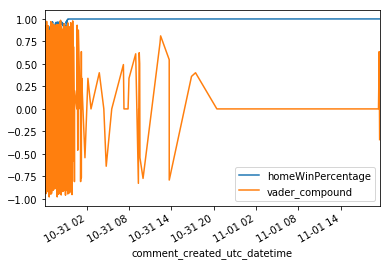

In [597]:
merged_with_sentiment.plot(x='comment_created_utc_datetime', y=['homeWinPercentage','vader_compound'])

In [566]:
comments[['comment_created_utc_datetime','comment_body']].head()

,comment_created_utc_datetime,comment_body
5610,2017-10-30 20:00:43,First. 0-0 Tie please
4331,2017-10-30 20:01:01,If this thread is filled with bad puns I swear
309,2017-10-30 20:01:15,Well the offense can't be any worse this week....
2932,2017-10-30 20:01:20,I am ready for some football! A Monday night p...
25,2017-10-30 20:01:22,"You guys may find this weird, but I find Sam P..."


In [567]:
merged['mytime'] = merged['comment_created_utc_datetime'] + timedelta(hours=5)

In [576]:
merged[['comment_created_utc_datetime','author_flair','comment_body_parsed','text','mytime','matched_play_by_play_utc']].loc[5000]

comment_created_utc_datetime                                  2017-10-30 21:44:31
author_flair                                                              Broncos
comment_body_parsed                 Vance Joseph fucking sucks. Bench his ass NOW
text                            (4:00) K.Hunt up the middle to KC 21 for no ga...
mytime                                                        2017-10-31 02:44:31
matched_play_by_play_utc                                      2017-10-31 01:45:04
Name: 5000, dtype: object

In [605]:
# comments.plot(x='comment_created_utc_datetime',
#               y='winpct',
#               xlim = (pd.to_datetime('2018-01-21 14:00'),
#                       pd.to_datetime('2018-01-21 20:00')),
#              figsize=(15,5))

In [413]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def calculate_VADER(comment):
    comment = str(comment)
    ss = sid.polarity_scores(comment)
    neg = ss['neg']
    neu = ss['neu']
    pos = ss['pos']
    compound = ss['compound']
    return ss, neg, neu, pos, compound

def vader_df(df, textcol = 'text'):
    df['ss'], df['neg'], df['neu'], df['pos'], df['compound'] = \
    zip(*df[textcol].map(calculate_VADER))
    return df

/home/robmulla/miniconda3/envs/w266/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [418]:
comments = vader_df(comments, textcol='comment_body')

def create_rolling(df, window=200):
    df['pos_rolling'] = df['pos'].rolling(window=window).mean()
    df['neg_rolling'] = df['neg'].rolling(window=window).mean()
    df['neu_rolling'] = df['neu'].rolling(window=window).mean()
    df['compound_rolling'] = df['compound'].rolling(window=window).mean()
    return df

def make_plot(df, additional_title_text=''):
    df['compound_rolling'] = df['compound_rolling'] * 2
    df.plot(x='comment_created_utc_datetime', y=['winodds',
                                                 'compound_rolling'],
              xlim = (pd.to_datetime('2018-01-21 14:50'),
                      pd.to_datetime('2018-01-21 18:30')),
             figsize=(15,10),
             title='Jags Patriots Jan 21 2018 - Sentiment Analysis {}'.format(additional_title_text),
           grid=False)

    plt.axhline(0, color='black', ls='--')

    plt.show()

NameError: name 'plt' is not defined

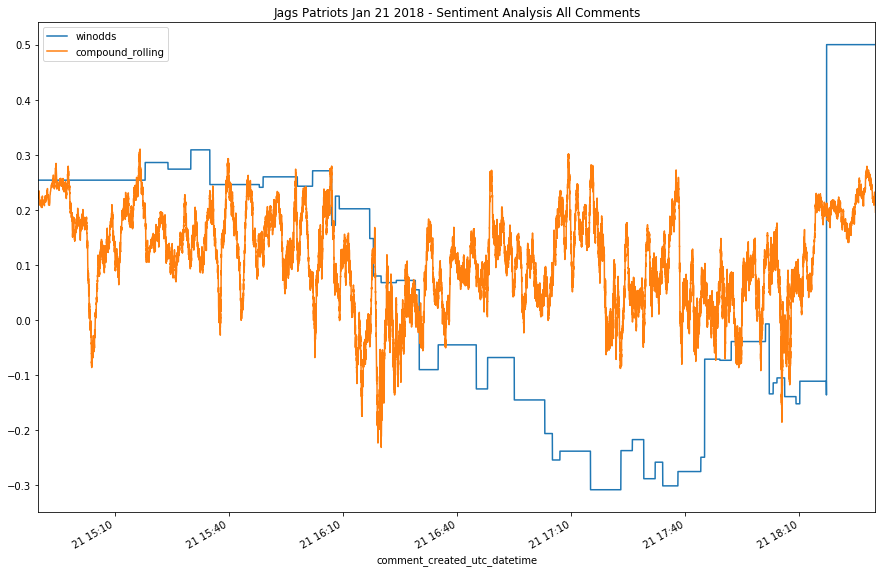

In [419]:
comments = create_rolling(comments, 300)
comments['winodds'] = (comments['winpct'] - 0.5)
make_plot(comments, additional_title_text='All Comments')

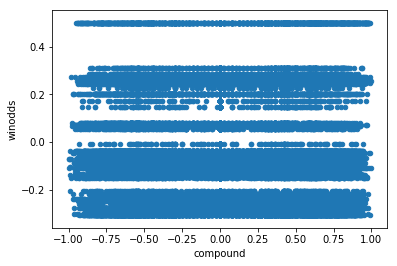

In [424]:
comments.plot('compound','winodds', kind='scatter')

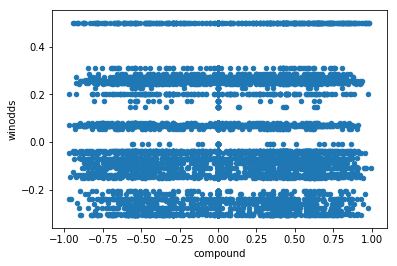

In [427]:
comments.loc[comments['author_flair'] == 'Patriots'].plot('compound','winodds', kind='scatter')

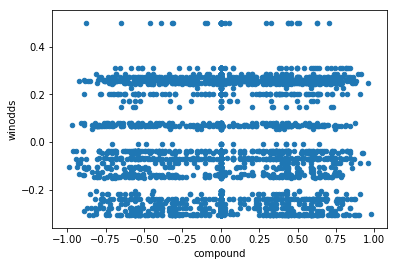

In [428]:
comments.loc[comments['author_flair'] == 'Eagles'].plot('compound','winodds', kind='scatter')